## Imports

In [4]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch import Tensor

from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
    torch_sparse,
)

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse, to_undirected
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, knn_graph
from torch_geometric.datasets import QM9
from torch_scatter import scatter
from torch_cluster import knn

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf', 'png')
from matplotlib.colors import to_rgb
import seaborn as sns
sns.reset_orig()
sns.set()
import networkx as nx
import torch_geometric
import random

import os
os.environ['TORCH'] = torch.__version__

from torch_geometric.utils.convert import to_networkx

## Tensors

In [5]:
x_ = torch.Tensor(2,3,4) #This returns a 3-dimensional tensor with 2 elements of size 3 by 4.
y1 = torch.tensor([2, 4, 8]) #1D tensor
y2 = torch.tensor([[2, 4, 6], [8, 10, 12]]) #2D tensor
y3 = torch.tensor([[[1, 2, 3], [4, 5, 6], [7, 8, 9]],[[10, 11, 12], [13, 14, 15], [16, 17, 18]]]) #3D tensor
d1, d2, d3 = y3.shape
dim1, dim2, dim3 = y3.size()
print(x_, "Shape : ", x_.shape, "Size : ", x_.size())
print(y1, "Shape : ", y1.shape, "Size : ", y1.size())
print(y2, "Shape : ", y2.shape, "Size : ", y2.size())
print(y3, "Shape : ", y3.shape, "Size : ", y3.size())
print(d1)
print(d2)
print(d3)
print(dim1)
print(dim2)
print(dim3)

tensor([[[ 7.3984e+31,  4.2038e+30,  2.4803e-43,  0.0000e+00],
         [-4.7261e+27,  3.2779e-41, -1.4699e+01,  4.5849e-41],
         [ 1.3250e+31,  2.8381e+23,  6.9780e+22,  1.4582e-19]],

        [[ 4.5415e+24,  4.0072e-11,  1.1703e-19,  1.5637e-01],
         [ 1.8475e+20,  7.1775e+22,  1.2011e+27,  4.7408e+16],
         [ 7.9424e+17,  6.9841e+16,  9.9616e+17,  1.3556e-19]]]) Shape :  torch.Size([2, 3, 4]) Size :  torch.Size([2, 3, 4])
tensor([2, 4, 8]) Shape :  torch.Size([3]) Size :  torch.Size([3])
tensor([[ 2,  4,  6],
        [ 8, 10, 12]]) Shape :  torch.Size([2, 3]) Size :  torch.Size([2, 3])
tensor([[[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8,  9]],

        [[10, 11, 12],
         [13, 14, 15],
         [16, 17, 18]]]) Shape :  torch.Size([2, 3, 3]) Size :  torch.Size([2, 3, 3])
2
3
3
2
3
3


## Neural networks
A neural network is basically a function with inputs and outputs. Any neural network can be defined as a function $\bar{\bar{y}} = f(\bar{\bar{x}})$ where the inputs and outputs can, in general, be a tensor.
A linear neural network is a function involving linear transformations.   
[Linear network layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear)

In [6]:
f = nn.Linear(2,1) #2 inputs and 1 output
print("network_structure", f)
print("network_weight", f.weight) #automatically setted weight value each time
print("network_bias", f.bias) #automatically setted bias value each time
x = torch.Tensor([2,4])
y = f.forward(x) #y = f(x), evaluation using forward() function
print(y)

network_structure Linear(in_features=2, out_features=1, bias=True)
network_weight Parameter containing:
tensor([[0.5259, 0.1995]], requires_grad=True)
network_bias Parameter containing:
tensor([0.2029], requires_grad=True)
tensor([2.0525], grad_fn=<ViewBackward0>)


## Class
Python is an object oriented programming language. Almost everything in Python is an object, with its properties (parameters) and methods. A class is like an object constructor, or a "blueprint" for creating objects.
## Creating a class
To create a class, use the keyword class.


In [ ]:
class object_constructor :
  x = 5
  y = 10 #x and y are the properties (parameters) of the object "object_constructor".

class_1 = object_constructor() #object is created.
print(class_1.x) #accessing properties.
print(class_1.y) #accessing properties.

5
10


## \__init__\() function
The examples above are classes and objects in their simplest form, and are not really useful in real life applications. All classes have a function called \__init__\(), which is always executed when the class is being initiated.The \__init__\() method allows us to initialize the attributes (variables) of an object.

In [ ]:
class biodata :
  def __init__(self, name, age):
    self.name = name
    self.age = age

p1 = biodata("Jerry", 23)
print(p1.name)
print(p1.age)

Jerry
23


## Inheritance
Inheritance allows us to define a class that inherits all the methods and properties from another class. Parent class is the class being inherited from, also called base class. Child class is the class that inherits from another class, also called derived class.

## super() function
Function used to give access to the methods of a parent class. Returns a temporary object of a parent class when used.

In [ ]:
class old_id :
  def __init__(self, name, programme, roll_number, department) :
    self.name = name
    self.roll_number = roll_number
    self.programme = programme
    self.department = department

  def info(self) :
    print(self.name, str(self.roll_number), self.programme, self.department)

ganesh_id = old_id("Ganesh Hasda", "BT", 190329, "Aerospace_engineering")
ganesh_id.info()

class new_id(old_id) :
  def __init__(self, name, programme, roll_number, department, new_department) :
    super().__init__(name, programme, roll_number, department)
    self.new_department = new_department

ganesh_19816329 = new_id("Ganesh Hasda", "BT-MS", 19816329, "Physics", "Physics")
ganesh_19816329.info()

Ganesh Hasda 190329 BT Aerospace_engineering
Ganesh Hasda 19816329 BT-MS Physics


## Message passing neural network (MPNN)

In [ ]:
f_1 = nn.Linear(11, 4)
f_2 = nn.Linear(11, 4)
f_3 = nn.Linear(11, 4)
h_0 = torch.tensor([1, 2, 3, 4], dtype = torch.float32)
print("initial_value : ", h_0)
h_1 = torch.tensor([2, 4, 6, 8], dtype = torch.float32)
e_01 = torch.tensor([3, 6, 9], dtype = torch.float32)
input_1 = torch.cat((h_0, h_1, e_01), -1)
print(input_1)
new_e_01 = f_1.forward(input_1)
print(new_e_01)

h_2 = torch.tensor([3, 5, 7, 9], dtype = torch.float32)
e_02 = torch.tensor([4, 7, 10], dtype = torch.float32)
input_2 = torch.cat((h_0, h_2, e_02), -1)
print(input_2)
new_e_02 = f_2.forward(input_2)
print(new_e_02)

h_3 = torch.tensor([4, 6, 8, 10], dtype = torch.float32)
e_03 = torch.tensor([5, 8, 11], dtype = torch.float32)
input_3 = torch.cat((h_0, h_3, e_03), -1)
print(input_3)
new_e_03 = f_3.forward(input_3)
print(new_e_03)

e = new_e_01 + new_e_02 + new_e_03 #aggregation as sum
print(e)

#Updating the h_0 value
f_new = nn.Linear(8, 4)
inp_4 = torch.cat((h_0, e), -1)
print(inp_4)
h_updtd = f_new.forward(inp_4)
print(h_updtd)
h_0 = h_updtd
print("new_value : ", h_0)

initial_value :  tensor([1., 2., 3., 4.])
tensor([1., 2., 3., 4., 2., 4., 6., 8., 3., 6., 9.])
tensor([ 2.4753, -2.7340, -1.1100, -4.2329], grad_fn=<ViewBackward0>)
tensor([ 1.,  2.,  3.,  4.,  3.,  5.,  7.,  9.,  4.,  7., 10.])
tensor([ 2.3132, -1.2655, -1.4807,  9.6297], grad_fn=<ViewBackward0>)
tensor([ 1.,  2.,  3.,  4.,  4.,  6.,  8., 10.,  5.,  8., 11.])
tensor([-1.8609, -4.0733,  0.3668, -2.6302], grad_fn=<ViewBackward0>)
tensor([ 2.9277, -8.0728, -2.2239,  2.7666], grad_fn=<AddBackward0>)
tensor([ 1.0000,  2.0000,  3.0000,  4.0000,  2.9277, -8.0728, -2.2239,  2.7666],
       grad_fn=<CatBackward0>)
tensor([-0.9136,  1.0289, -0.1095,  1.0378], grad_fn=<ViewBackward0>)
new_value :  tensor([-0.9136,  1.0289, -0.1095,  1.0378], grad_fn=<ViewBackward0>)


## MPNN Layer
A class inherited from the parent class 'MessagePassing' is created. This class has two neural networks for creating messages and updating the node features at the nodes. It has the following parameters and inputs :   
1. $d$ : node feature dimension
1. $d_e$ : edge feature dimension
1. $H$ : node features matrix, $H_{n \times d}$, $n$ is the total number of nodes
1. $E$ : edge features matrix, $E_{e \times d_e}$, $e$ is the total number of directed edges
1. $E_{in}$ : edge index matrix, $(E_{in})_{2 \times e}$, a matrix description of edge connections
1. $H'$ : updated node features matrix, $H'_{n \times d}$, $n$ is the total number of nodes

In [7]:
class MPNN(MessagePassing) :
  def __init__(self, hid_dim, edge_dim, aggr = "add") :
    super().__init__(aggr = aggr)
    self.hid_dim = hid_dim
    self.edge_dim = edge_dim
    self.psi = nn.Linear(2*hid_dim + edge_dim, hid_dim)
    self.phi = nn.Linear(2*hid_dim, hid_dim)

  #The forward() function must comprise of whole message passing process i.e creating messages, aggregation and finally updation.
  #It updates the feature vector at the i-th node after one round of message passing.
  #The MessagePassing parent class has the propagate() function for doing the whole message passing process using the functions, message(), aggregate() and update()

  def forward(self, h, edge_index, edge_attr) :
    #The arguments are initial node feature vector h, edge feature vectors (edge_attr) and edge index giving informations of source node and destination node.
    #The output is the updated feature vector of each node.
    #The propagate() function internally calls the functions message(), aggregate() and update().
    new_h = self.propagate(edge_index, h = h, edge_attr = edge_attr)
    return new_h

  def message(self, h_i, h_j, edge_attr) :
    m_ij = torch.cat((h_i, h_j, edge_attr), -1) #joining tensors
    return self.psi(m_ij)

  def aggregate(self, inputs, index) :
    return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

  def update(self, aggr_out, h) :
    upd_out = torch.cat((aggr_out, h), -1)
    return self.phi(upd_out)

## Visualizing graphs

In [ ]:
def visualize_graph(G, color='blue'):

    G = to_networkx(G)
    plt.figure(figsize=(8,5))
    plt.xticks([])
    plt.yticks([])

    #fig, ax = plt.subplots(nrows=1, ncols=2)
    plt.subplot(2, 2, 1)
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
<ipython-input-14-41b20dfd79fe>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


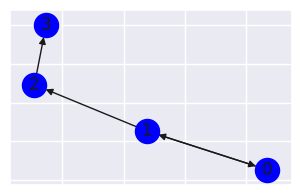

In [ ]:
edge_index_1 = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 3]], dtype=torch.long)
x_1 = torch.tensor([[-1], [0], [1], [2]], dtype=torch.float) #data at nodes.
data_1 = Data(edge_index=edge_index_1) #ignoring data at nodes.
visualize_graph(data_1)

In [9]:
msg_net = MPNN(5, 3)
H = torch.tensor([[1, 2, 3, 4, 5], [5, 6, 7, 8, 9], [9, 10, 11, 12, 13], [13, 14, 15, 16, 17]], dtype = torch.float32)
print("The node feature matrix is", H)
E_in = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 3]])
E = torch.tensor([[3, 6, 9], [12, 15, 18], [21, 24, 27], [30, 33, 36]], dtype = torch.float32)
y = msg_net(H, E_in, E)
print("The updated node feature matrix is", y)

The node feature matrix is tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 9., 10., 11., 12., 13.],
        [13., 14., 15., 16., 17.]])
The updated node feature matrix is tensor([[-2.4388,  1.1194,  0.2999, -0.1774, -1.2601],
        [-1.1005,  2.1195,  0.7723, -0.2922,  1.2422],
        [-2.7432,  4.3755,  0.8628, -1.5213,  0.3077],
        [-3.8338,  6.3175,  1.0444, -2.2886,  0.1364]],
       grad_fn=<AddmmBackward0>)
